Homework 2: Clustering
=============

### Deadline: June 18, 11:59 pm

### Dr. Mahdi Roozbahani

In this homework, you will have the chance to implement two algorithms for clustering, namely the KMeans and Gaussian Mixture Model (GMM). Specifically:

- Implement K-Means algorithm, as well as the helper function like fast pairwise distance.
- Implement GMM, as well as the numerical stable helper functions.


## 0. Setup

This notebook is tested under [python 3.6.8](https://www.python.org/downloads/release/python-368/), and the corresponding packages can be downloaded from [miniconda](https://docs.conda.io/en/latest/miniconda.html). You may also want to get yourself familiar with several packages:

- [jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/)
- [numpy](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [matplotlib](https://matplotlib.org/users/pyplot_tutorial.html)


## Instructions about the assignment

- For coding questions: you are asked to fill in the blanks in the code cells.
- After you have completed your coding, please restart your kernel and run your notebook from start to finish before you submit (so we don't have to re-run it!)
- Your notebook should not take more than 10 minutes to run (ours runs in < 2 minutes)

You are only allowed to use the packages imported below. Other packages like scipy, sklearn are not allowed in this homework. The purpose is to let you write most part of the algorithms from scratch, so you can have a better understanding about them.

- For writing questions: you are asked to answer them in the markdown cells.

You can also type the Latex equations in the markdown cell. 
To switch between cell for code and for markdown, see the menu -> Cell -> Cell Type

In [116]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

%matplotlib inline  

import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm_notebook as tqdm

print('Version information')

print('python: {}'.format(sys.version))
print('matplotlib: {}'.format(matplotlib.__version__))
print('numpy: {}'.format(np.__version__))

# Set random seed so output is all same
np.random.seed(1)

Version information
python: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
matplotlib: 3.0.3
numpy: 1.16.2


# 1. Helper functions [20 pts]

In this section, you are asked to implement several mathematical functions that will be used later in your implementation for KMeans and GMM. 

You are expected to receive the exact same output with your implementation.

## pairwise distance [7 pts]

Given $X \in \mathbb{R}^{N x D}$ and $Y \in \mathbb{R}^{M x D}$, obtain the pairwise distance matrix $dist \in \mathbb{R}^{N x M}$, where $dist_{i, j} = ||X_i - Y_j||_2$.  

**DO NOT USE A FOR LOOP** in your implementation -- they are slow and will make your code too slow to pass our grader.  Use array broadcasting instead.

In [131]:
def pairwise_dist(x, y):
    """
    Args:
        x: N x D numpy array
        y: M x D numpy array
    Return:
        dist: N x M array, where dist2[i, j] is the euclidean distance between 
        x[i, :] and y[j, :]
    """
    "dist = np.linalg.norm(y - x[:, None], axis=2)"
    dist = np.sqrt(np.sum(np.square(x[:,np.newaxis,:] - y), axis=2))
    return dist
    raise NotImplementedError


# Check answer
np.random.seed(1)
x = np.random.randn(2, 2)
y = np.random.randn(3, 2)
print("*** Expected Answer ***")
print("""==x==
[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]]
==y==
[[ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]]
==dist==
[[1.85239052 0.19195729 1.35467638]
 [1.85780729 2.29426447 1.18155842]]""")


print("\n*** My Answer ***")
print("==x==")
print(x)
print("==y==")
print(y)
print("==dist==")
print(pairwise_dist(x, y))

*** Expected Answer ***
==x==
[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]]
==y==
[[ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]]
==dist==
[[1.85239052 0.19195729 1.35467638]
 [1.85780729 2.29426447 1.18155842]]

*** My Answer ***
==x==
[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]]
==y==
[[ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]]
==dist==
[[1.85239052 0.19195729 1.35467638]
 [1.85780729 2.29426447 1.18155842]]


## softmax [7 pts]

Given $logit \in \mathbb{R}^{N x D}$, calculate $prob \in \mathbb{R}^{N x D}$, where $prob_{i, j} = \frac{\exp(logit_{i, j})}{\sum_{d=1}^D exp(logit_{i, k})}$.

Note that it is possible that $logit_{i, j}$ is very large, making $\exp(\cdot)$ of it to explode. To make sure it is numerical stable, you may need to subtract the maximum for each row of $logits$.  As in calculating pairwise distances, DO NOT USE A FOR LOOP.

In [118]:
def softmax(logits):
    MaxValues = logits.max(axis=1)[:,None]
    logits = logits - MaxValues
    num = np.exp(logits)
    denum = np.transpose(np.array([num.sum(axis=1)]))
    SoftMaxMatrix = num/denum
    return SoftMaxMatrix
    raise NotImplementedError

logits = np.array([[1000, 1000],
                   [1, 2]], dtype=np.float32)

print("""Correct answer:
===softmax===
[[0.5        0.5       ]
 [0.26894143 0.7310586 ]]""")

print("\nMy answer:")
print(softmax(logits))

Correct answer:
===softmax===
[[0.5        0.5       ]
 [0.26894143 0.7310586 ]]

My answer:
[[0.5        0.5       ]
 [0.26894143 0.7310586 ]]


## logsumexp [6 pts]

Given $logit \in \mathbb{R}^{N x D}$, calculate $s \in \mathbb{R}^N$, where $s_i = \log \big( \sum_{j=1}^D \exp(logit_{i, j}) \big)$. Again, pay attention to the numerical problem. You may want to use similar trick as in the softmax function.  DO NOT USE A FOR LOOP.

In [119]:
def logsumexp(logits):
    """
    Args:
        logits: N x D numpy array
    Return:
        s: N x 1 array where s[i,0] = logsumexp(logits[i,:])
    """
    MaxValues = logits.max(axis=1)[:,None]
    logits = logits - MaxValues
    
    num = np.exp(logits)
    logsum = np.log(np.transpose(np.array([num.sum(axis=1)])))
    
    LogSumExp = MaxValues+logsum
    
    return LogSumExp
    raise NotImplementedError

logits = np.array([[1000, 1000], 
                   [1, 2]], dtype=np.float32)
print("""Correct Answer:
===logsumexp===
[[1000.6932   ]
 [   2.3132617]]""")

print("\nMy answer: ")
print(logsumexp(logits))

Correct Answer:
===logsumexp===
[[1000.6932   ]
 [   2.3132617]]

My answer: 
[[1000.6932   ]
 [   2.3132617]]


In [120]:
# below are some helper functions for plot.
# you don't have to modify them. 

def plot_images(img_list, title_list, figsize=(11, 6)):
    assert len(img_list) == len(title_list)
    fig, axes = plt.subplots(1, len(title_list), figsize=figsize)
    for i, ax in enumerate(axes):
        ax.imshow(img_list[i] / 255.0)
        ax.set_title(title_list[i])
        ax.axis('off')

def plot_scatter(samples, ids):
    colors = np.zeros((len(ids), 3))
    choices = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    num_points = []
    for i in range(3):
        num_points.append(np.sum(ids == i))
    maps = np.argsort(num_points)
    for i in range(3):
        colors[np.where(ids == maps[i]), :] = choices[i]
    plt.scatter(samples[:, 0], samples[:, 1], s=1, color=colors)
    plt.axis('equal')

# 2. KMeans implementation [30 pts]

KMeans is trying to solve the following optimization problem:

\begin{align}
\arg \min_S \sum_{i=1}^K \sum_{x_j \in S_i} ||x_j - \mu_i||^2
\end{align}
where one needs to partition the N observations into K sets: $S = \{S_1, S_2, \ldots, S_K\}$ and each set has $\mu_i$ as its center.

In this section, you are asked to implement the kmeans algorithm. Below is a template which requires you to implement some member functions that haven't been implemented yet.

For the function signature, please see the corresponding doc strings.

In [129]:
class KMeans(object):

    def __init__(self): #No need to implement
        pass

    def _init_centers(self, points, K, **kwargs):
        """
        Args:
            points: NxD numpy array, where N =256 x 256 = 65536 is # points and D = 3 is the dimensionality
            K: number of clusters = 5
            kwargs: any additional arguments you want
        Return:
            centers: K x D numpy array, the centers. 
        """
        rows, cols = points.shape
        D = cols
        centers = np.random.randint(256, size = K*D)
        centers.resize(K,D)
        "b = np.random.randint(256, size = D*K)"
        "centers = np.c_[a, b]"
        print(centers)
        "raise NotImplementedError"

    def _update_assignment(self, centers, points):
        """
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            points: NxD numpy array, the observations
        Return:
            cluster_idx: numpy array of length N, the cluster assignment for each point
            
        Hint: You could call pairwise_dist() function. 
        """
        z = pairwise_dist(centers, points)
        print(z)
        raise NotImplementedError

    def _update_centers(self, old_centers, cluster_idx, points):
        """
        Args:
            old_centers: old centers KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            centers: new centers, K x D numpy array, where K is the number of clusters, and D is the dimension.
        """
        raise NotImplementedError

    def _get_loss(self, centers, cluster_idx, points):
        """
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            loss: a single float number, which is the objective function of KMeans. 
        
        Hint: The loss equals to the average squared distance for all the observation points. 
              You could call pairwise_dist() function which you have implemented to get the distance.
        """
        raise NotImplementedError
        
    def __call__(self, points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, **kwargs):
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            max_iters: maximum number of iterations (Hint: You could change it when debugging)
            abs_tol: convergence criteria w.r.t absolute change of loss
            rel_tol: convergence criteria w.r.t relative change of loss
            kwargs: any additional arguments you want
        Return:
            cluster assignments: Nx1 int numpy array
            cluster centers: K x D numpy array, the centers
        
        Hint: You do not need to change it. For each iteration, we update the centers and calculate the loss.
        If the loss between two iterations qualify our two conditions, then we will stop the iteraion and return our centers.
        """
        centers = self._init_centers(points, K, **kwargs)
        pbar = tqdm(range(max_iters))
        for it in pbar:
            cluster_idx = self._update_assignment(centers, points)
            centers = self._update_centers(centers, cluster_idx, points)
            loss = self._get_loss(centers, cluster_idx, points)
            K = centers.shape[0]
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            pbar.set_description('iter %d, loss: %.4f' % (it, loss))
        return cluster_idx, centers

Let's try a simple image pixel clustering, which tries to compress the image using 5 colors:

In [132]:
image = imageio.imread('fruit.bmp')
im_height, im_width, im_channel = image.shape

flat_img = np.reshape(image, [-1, im_channel]).astype(np.float32)
print(flat_img.shape)
cluster_ids, centers = KMeans()(flat_img, K=5)

kmeans_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))

plot_images([image, kmeans_img], ['origin', 'kmeans'])

(65536, 3)
[[157 142  50]
 [ 68 215 215]
 [233 241 247]
 [222  96  86]
 [141 233 137]]


TypeError: 'NoneType' object is not subscriptable

and 16 colors:

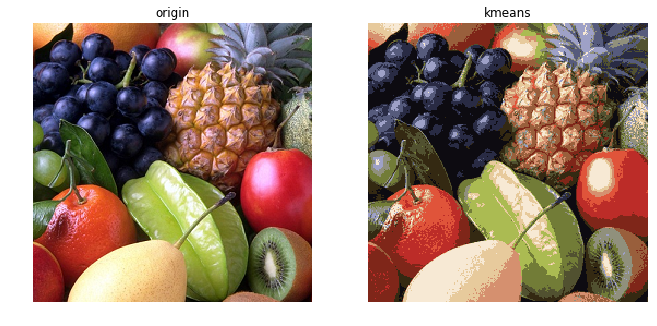

In [12]:
cluster_ids, centers = KMeans()(flat_img, K=16, max_iters=100)

kmeans_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))

plot_images([image, kmeans_img], ['origin', 'kmeans'])

# 3. GMM implementation [30 pts]

GMM is trying to do MLE (maximum likelihood estimation). It approximates the distribution of data using a set of gaussian distributions. Here we assume that each gaussian component has diagonal covariance matrix, which makes it easier to calculate the density. 

Given $N$ samples $X = [x_1, x_2, \ldots, x_N]$, we are asked to find $K$ diagonal gaussian distributions to model the data $X$: 

\begin{align}
    \max_{\{\mu_k, \sigma_k\}_{k=1}^K} \sum_{i=1}^N \log \big( \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \sigma_k)\big)
\end{align}

**Hints**

1. Here $\pi(\cdot)$ is the prior of the latent variable. To make it simple, we assume $\pi(k) = \frac{1}{K}, \forall k = 1, 2, \ldots, K$.

2. As we create our model, we will need to use a multivariate Gaussian since our pixels are 3-dimensional vectors corresponding to red, green, and blue color intensities.  For simplicity, we will also assume that our components are independent (i.e. the red intensity of a pixel is independent from its blue intensity, etc).  This allows us to simplify the computation. 

The following example from a machine learning textbook may be helpful:

![title](mvn.png)

3. At EM steps, gamma means $\tau\left(z_{n k}\right)$ at our slide of GMM.

4. For E steps, we already get the log-likelihood at ll_joint() function. For the fomula at our slide:
$$
\tau\left(z_{n k}\right)=\frac{\pi_{k} N\left(x_{n} | \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} N\left(x_{n} | \mu_{j}, \Sigma_{j}\right)},
$$
ll_joint equals to the $N$ here. Thus, You should be able to finish E steps with just a few lines of code by using ll_joint() and softmax() defined above.

In [21]:
class GMM(object):
    def __init__(self): # No need to implement
        pass
        
    def _init_components(self, points, K, **kwargs):
        """
        Args:
            points: NxD numpy array, the observations
            K: number of components
            kwargs: any other args you want
        Return:
            pi: numpy array of length K, prior
            mu: KxD numpy array, the center for each gaussian. 
            sigma: KxD numpy array, the diagonal standard deviation of each gaussian.
            
        Hint: You could use the K-means results to initial GMM. It will help to converge. 
        For instance, you could use ids, mu = KMeans()(points, K)  to initialize.
        """
        raise NotImplementedError

    def _ll_joint(self, points, pi, mu, sigma):
        """
        Args:
            points: NxD numpy array, the observations
            pi: np array of length K, the prior of each component
            mu: KxD numpy array, the center for each gaussian. 
            sigma: KxD numpy array, the diagonal standard deviation of each gaussian.
        Return:
            ll(log-likelihood): NxK array, where ll(i, j) = log pi(j) + log NormalPDF(points_i | mu[j], sigma[j])
            
        Hint: Assume that the three dimensions of our multivariate gaussian are independent.  
              This allows you to write treat it as a product of univariate gaussians.
        """
        raise NotImplementedError

    def _E_step(self, points, pi, mu, sigma):
        """
        Args:
            points: NxD numpy array, the observations
            pi: np array of length K, the prior of each component
            mu: KxD numpy array, the center for each gaussian. 
            sigma: KxD numpy array, the diagonal standard deviation of each gaussian.
        Return:
            gamma: NxK array, the posterior distribution (a.k.a, the soft cluster assignment) for each observation.
            
        Hint: You should be able to do this with just a few lines of code by using _ll_joint() and softmax() defined above. 
        """
        raise NotImplementedError

    def _M_step(self, points, gamma):
        """
        Args:
            points: NxD numpy array, the observations
            gamma: NxK array, the posterior distribution (a.k.a, the soft cluster assignment) for each observation.
        Return:
            pi: np array of length K, the prior of each component
            mu: KxD numpy array, the center for each gaussian. 
            sigma: KxD numpy array, the diagonal standard deviation of each gaussian. 
            
        Hint:  There are formulas in the slide.
        """
        raise NotImplementedError

    def __call__(self, points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, **kwargs):
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            max_iters: maximum number of iterations
            abs_tol: convergence criteria w.r.t absolute change of loss
            rel_tol: convergence criteria w.r.t relative change of loss
            kwargs: any additional arguments you want
        Return:
            gamma: NxK array, the posterior distribution (a.k.a, the soft cluster assignment) for each observation.
            (pi, mu, sigma): (1xK np array, KxD numpy array, KxD numpy array), mu and sigma.
        
        Hint: You do not need to change it. For each iteration, we process E and M steps, then 
        """        
        pi, mu, sigma = self._init_components(points, K, **kwargs)
        
        pbar = tqdm(range(max_iters))
        for it in pbar:
            # E-step
            gamma = self._E_step(points, pi, mu, sigma)
            
            # M-step
            pi, mu, sigma = self._M_step(points, gamma)
            
            # calculate the negative log-likelihood of observation
            joint_ll = self._ll_joint(points, pi, mu, sigma)
            loss = -np.sum(logsumexp(joint_ll))
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            pbar.set_description('iter %d, loss: %.4f' % (it, loss))
        return gamma, (pi, mu, sigma)


Let's try a simple image pixel clustering, which tries to compress the image using 5 colors:

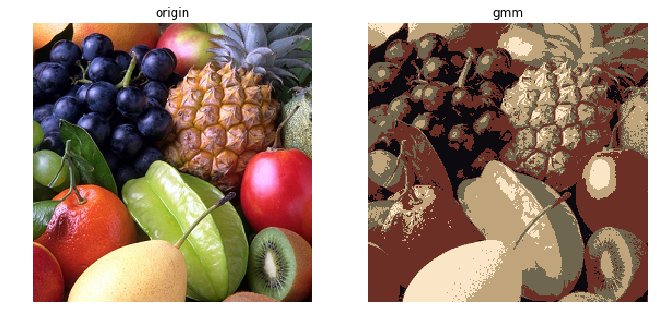

In [23]:
image = imageio.imread('fruit.bmp')
im_height, im_width, im_channel = image.shape
flat_img = np.reshape(image, [-1, im_channel]).astype(np.float32)
gamma, (pi, mu, sigma) = GMM()(flat_img, K=5, max_iters=100)
cluster_ids = np.argmax(gamma, axis=1)
centers = mu

gmm_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))

plot_images([image, gmm_img], ['origin', 'gmm'])

and 16 colors

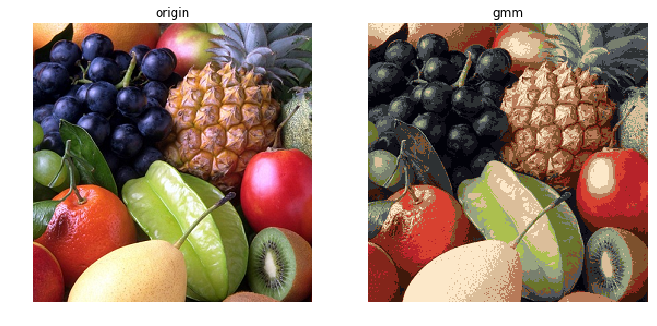

In [24]:
gamma, (pi, mu, sigma) = GMM()(flat_img, K=16, max_iters=100)
cluster_ids = np.argmax(gamma, axis=1)
centers = mu

gmm_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))

plot_images([image, gmm_img], ['origin', 'gmm'])

# 3. Compare KMeans with GMM [10 pts]

In this section, we are going to have a comparison between the two algorithms.

## mixture model

We first create a dataset that is sampled from the mixture model. To do so, you first need a sampling method, that can sample from this mixture model. The sampling procedure looks like this:

- first sample a component id according to prior distribution $\pi(\cdot)$
- then choose the corresponding gaussian distribution, and sample from that gaussian


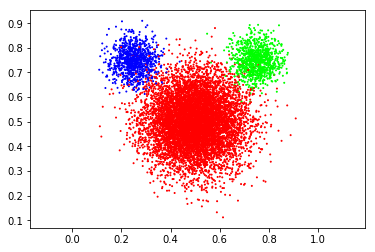

In [25]:
def gmm_sampling(num_samples, pi, mu, sigma):
    """
    Args:
        num_samples: number of samples required
        pi: np array of length K, the prior distribution, where K is # components
        mu: KxD np array, the center for each gaussian, where D is data dimension
        sigma: KxD np array, the standard deviation for each gaussian
    Return:
        samples: NxD np array, the result samples
        ids: np array of length N, the component id for each sample
        
    Hint: You could use np.random.randn() function.
    """
    raise NotImplementedError

pi = np.array([0.8, 0.1, 0.1])
mu = np.array([[0.5, 0.5], 
               [0.25, 0.75], 
               [0.75, 0.75]], dtype=np.float32)
sigma = np.array([[0.1, 0.1], 
                  [0.05, 0.05], 
                  [0.05, 0.05]], dtype=np.float32)
samples, ids = gmm_sampling(10000, pi, mu, sigma)
plot_scatter(samples, ids)

Let's see how KMeans does in this case

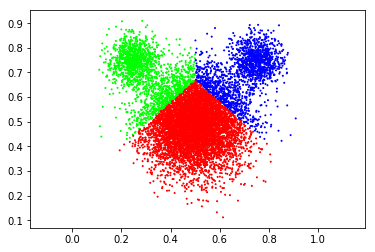

In [26]:
ids, centers = KMeans()(samples, K=3)
plot_scatter(samples, ids)

And GMM

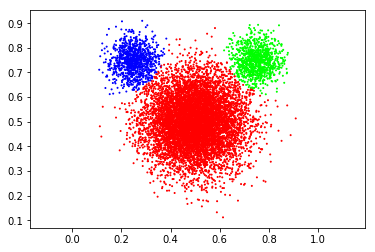

In [28]:
gamma, (pi, mu, sigma) = GMM()(samples, K=3, max_iters=100)
ids = np.argmax(gamma, axis=1)
plot_scatter(samples, ids)

# 4. Written Questions [10 pts]

In this section, you are asked to answer several question. You are expected to write down the answers in the notebook markdown cells (similar to the current one you are reading). You can also type Latex equations if necessary. 

## 4.1 Initialization. 

- What initialization method you used for KMeans and GMM, respectively? 

- Did you see different results after different runs of the same code? Why? 

Your answer goes here:



## 4.2 Convergence.

- Is it guaranteed that GMM with EM always converges to the optimal solution? 

- Is KMeans always guaranteed to converge (to some local optima)?

Your answer goes here:

